### Model selection and model tuning using cross-validation
This notebook compares two **hyperparameter tuned** machine learning models and selects the best one.
* [Gradient Boosting Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)
* [Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

This notebook also compares two hyperparameter tuning parameter search methodologies.
* [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
* [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

Adapted from [An Intro to Hyper-parameter Optimization using Grid Search and Random Search.](https://medium.com/@cjl2fv/an-intro-to-hyper-parameter-optimization-using-grid-search-and-random-search-d73b9834ca0a)

Overview:
* We have a regression problem and are trying to make the best prediction model.
* We are going to look at two options: **gradient boosting** and **random forest**.
* For each model, we need to find the best hyperparameters
    - Will demo an exhaustive grid search and randomized search
    - (Want to show you the randomized search is a lot faster and results almost as good

Steps:
1. Make a holdout set
2. EDA on training set
3. Find the best boosting hyperparameters
4. Fit boosting model using all the training set and the best hyperparameters
5. Find the best random forest hyperparameters
6. Fit the random forest model using all the training set and the best hyperparameters
7. Select the best model
    - based on cross validation results
    - based on performance on holdout set

In [1]:
# numpy, pandas, matplotlib, and seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# models
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

# train-test-split
from sklearn.model_selection import train_test_split

# hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# data
from sklearn.datasets import load_boston

# for timing our parameter searches
import time

# metrics
from sklearn.metrics import mean_squared_error

### The data

In [2]:
dataset = load_boston()

In [3]:
print(dataset.DESCR)  #  Classic dataset in machine learning
                      #  Median home value in 506 towns around Boston

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [4]:
dataset.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [5]:
dataset.data

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
        4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
        9.1400e+00],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
        4.0300e+00],
       ...,
       [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        5.6400e+00],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
        6.4800e+00],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        7.8800e+00]])

In [6]:
dataset.data.shape  # 506 rows, 13 columns

(506, 13)

In [7]:
dataset.target

array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9, 15. ,
       18.9, 21.7, 20.4, 18.2, 19.9, 23.1, 17.5, 20.2, 18.2, 13.6, 19.6,
       15.2, 14.5, 15.6, 13.9, 16.6, 14.8, 18.4, 21. , 12.7, 14.5, 13.2,
       13.1, 13.5, 18.9, 20. , 21. , 24.7, 30.8, 34.9, 26.6, 25.3, 24.7,
       21.2, 19.3, 20. , 16.6, 14.4, 19.4, 19.7, 20.5, 25. , 23.4, 18.9,
       35.4, 24.7, 31.6, 23.3, 19.6, 18.7, 16. , 22.2, 25. , 33. , 23.5,
       19.4, 22. , 17.4, 20.9, 24.2, 21.7, 22.8, 23.4, 24.1, 21.4, 20. ,
       20.8, 21.2, 20.3, 28. , 23.9, 24.8, 22.9, 23.9, 26.6, 22.5, 22.2,
       23.6, 28.7, 22.6, 22. , 22.9, 25. , 20.6, 28.4, 21.4, 38.7, 43.8,
       33.2, 27.5, 26.5, 18.6, 19.3, 20.1, 19.5, 19.5, 20.4, 19.8, 19.4,
       21.7, 22.8, 18.8, 18.7, 18.5, 18.3, 21.2, 19.2, 20.4, 19.3, 22. ,
       20.3, 20.5, 17.3, 18.8, 21.4, 15.7, 16.2, 18. , 14.3, 19.2, 19.6,
       23. , 18.4, 15.6, 18.1, 17.4, 17.1, 13.3, 17.8, 14. , 14.4, 13.4,
       15.6, 11.8, 13.8, 15.6, 14.6, 17.8, 15.4, 21

In [8]:
dataset.target.shape  # the targets (median house price)

(506,)

In [9]:
# set sklearn random seed
np.random.seed(42)

### Create the train and holdout sets

In [10]:
# All the data
X = dataset.data
y = dataset.target

In [11]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, 
                                                          shuffle=True,
                                                          test_size=0.2, 
                                                          random_state=11)

In [12]:
# check the shapes
print("Training shapes")
print(f"X: {X_train.shape}")
print(f"y: {y_train.shape}")
print("\nHoldout shapes")
print(f"X: {X_holdout.shape}")
print(f"y: {y_holdout.shape}")

Training shapes
X: (404, 13)
y: (404,)

Holdout shapes
X: (102, 13)
y: (102,)


### EDA
Will use seaborn's [pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html).  But to use it the data and target need to be together in a pandas dataframe.

In [13]:
Xy_train = np.hstack((X_train,y_train.reshape(-1,1)))
Xy_train.shape

(404, 14)

In [14]:
Xy_columns = np.hstack((dataset.feature_names,"MEDV"))
Xy_columns

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV'], dtype='<U7')

In [15]:
df_Xy_train = pd.DataFrame(data=Xy_train, columns=Xy_columns)
df_Xy_train.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.12579,45.0,3.44,0.0,0.437,6.556,29.1,4.5667,5.0,398.0,15.2,382.84,4.56,29.8
1,0.47547,0.0,9.90,0.0,0.544,6.113,58.8,4.0019,4.0,304.0,18.4,396.23,12.73,21.0
2,0.85204,0.0,8.14,0.0,0.538,5.965,89.2,4.0123,4.0,307.0,21.0,392.53,13.83,19.6
3,0.63796,0.0,8.14,0.0,0.538,6.096,84.5,4.4619,4.0,307.0,21.0,380.02,10.26,18.2
4,5.66998,0.0,18.10,1.0,0.631,6.683,96.8,1.3567,24.0,666.0,20.2,375.33,3.73,50.0


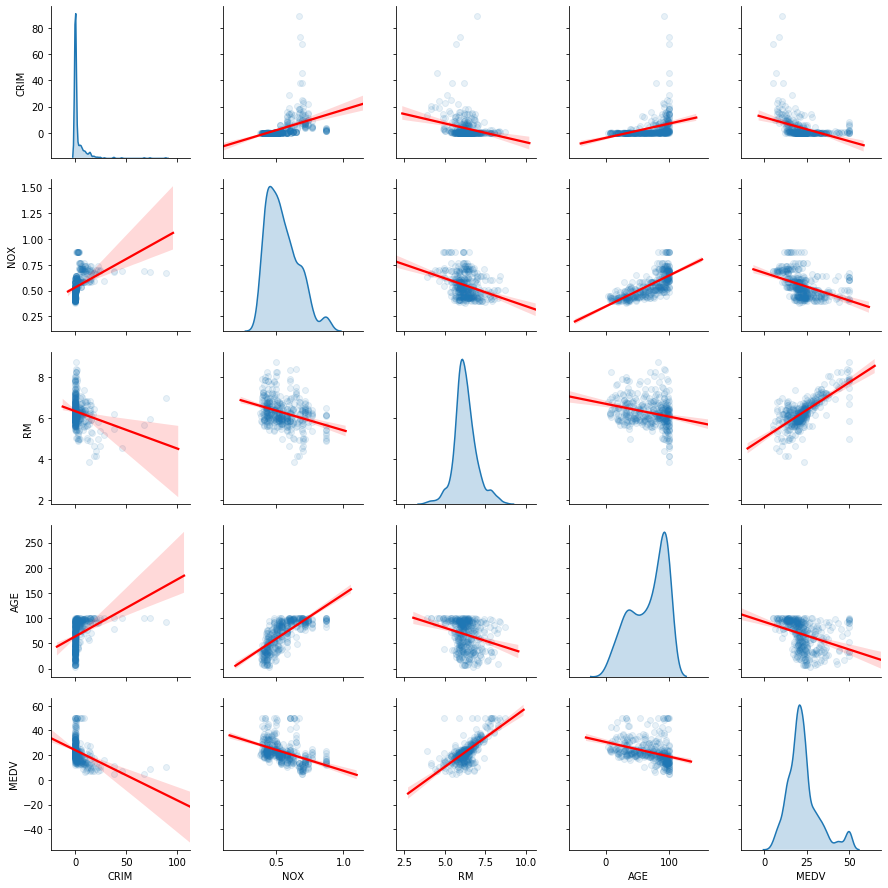

In [16]:
features_selected = ['CRIM', 'NOX', 'RM', 'AGE', 'MEDV']
g = sns.pairplot(df_Xy_train,
                 kind='reg',
                 diag_kind='kde',
                 x_vars = features_selected,
                 y_vars = features_selected,
                 plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}})

## Gradient boosting regressor

In [17]:
regressor = GradientBoostingRegressor()  # using default parameters! 
                                         # but will investigate best values below

In [18]:
# parameters we'd like to investigate
num_estimators = [10, 100, 1000]
learn_rates = [0.01, 0.1, 1]
max_depths = [1, 2, 3]
min_samples_split = [2, 10, 20]
min_samples_leaf = [2, 10, 20]

num_combinations = (len(num_estimators) *
                   len(learn_rates) *
                   len(max_depths) *
                   len(min_samples_split) *
                   len(min_samples_leaf))
                
print(f"In an exhaustive grid search, this is {num_combinations} simulations.")

# dictionary containing the parameters
param_grid = {'n_estimators': num_estimators,
              'learning_rate': learn_rates,
              'max_depth': max_depths,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf}

In an exhaustive grid search, this is 243 simulations.


### GridSearchCV for best parameters

In [19]:
grid_search = GridSearchCV(regressor, 
                           param_grid, 
                           scoring='neg_root_mean_squared_error',
                           cv=3,
                           verbose=1,
                           return_train_score=True,
                           n_jobs=-1)
time_start = time.time()
grid_search.fit(X_train, y_train)
time_end = time.time()

time_elapsed = time_end - time_start
print(f"Time elapsed: {time_elapsed:0.1f} seconds.")

print("\nThe best parameters:")
boosting_gridsearch_bestparams = grid_search.best_params_
print(grid_search.best_params_)

print("\nThe best score:")
boosting_gridsearch_bestscore = -1 * grid_search.best_score_
print(-1*grid_search.best_score_)  # negative root mean square error

Fitting 3 folds for each of 243 candidates, totalling 729 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 729 out of 729 | elapsed:   51.9s finished


Time elapsed: 53.3 seconds.

The best parameters:
{'learning_rate': 0.1, 'max_depth': 2, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 1000}

The best score:
3.067451727152774


### RandomizedSearchCV for best parameters

In [20]:
desired_iterations = 100 # you can set how many simulations to run

random_search = RandomizedSearchCV(regressor, 
                                   param_grid, 
                                   scoring='neg_root_mean_squared_error',
                                   cv=3,
                                   n_iter=desired_iterations,
                                   verbose=1,
                                   return_train_score=True,
                                   n_jobs=-1)

time_start = time.time()
random_search.fit(X_train, y_train)
time_end = time.time()

time_elapsed = time_end - time_start
print(f"Time elapsed: {time_elapsed:0.1f} seconds.")

print("\nThe best parameters:")
boosting_randomsearch_bestparams = random_search.best_params_
print(random_search.best_params_)

print("\nThe best score:")
boosting_randomsearch_bestscore = -1 * random_search.best_score_
print(-1*random_search.best_score_)  # negative root mean square error

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 285 out of 300 | elapsed:   17.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   19.0s finished


Time elapsed: 20.2 seconds.

The best parameters:
{'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_depth': 2, 'learning_rate': 0.1}

The best score:
3.0674387255523445


### Select the best gradient boosting model

In [21]:
print('Best gradient boosting score and parameters')
print('\nFrom exhaustive grid search:')
print(f'rmse: {boosting_gridsearch_bestscore:0.3f}')
print(f'parameters: {boosting_gridsearch_bestparams}')
print('\nFrom randomized search:')
print(f'rmse: {boosting_randomsearch_bestscore:0.3f}')
print(f'parameters: {boosting_randomsearch_bestparams}')
print('\nThe searches found identical parameters.')

Best gradient boosting score and parameters

From exhaustive grid search:
rmse: 3.067
parameters: {'learning_rate': 0.1, 'max_depth': 2, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 1000}

From randomized search:
rmse: 3.067
parameters: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_depth': 2, 'learning_rate': 0.1}

The searches found identical parameters.


### Train the best boosting model on all the training data

In [22]:
boosting_model = GradientBoostingRegressor(learning_rate=0.1,
                                           max_depth=2,
                                           min_samples_leaf=10,
                                           min_samples_split=2,
                                           n_estimators=1000)

boosting_model.fit(X_train, y_train)

print("This is our best boosting model.  Now let's build our best Random Forest model.")

This is our best boosting model.  Now let's build our best Random Forest model.


## Random forest regressor

In [23]:
regressor = RandomForestRegressor()  # using default parameters! 
                                     # but will investigate best values below

### Let's find the best hyperparameters

In [24]:
# parameters we'd like to investigate
num_estimators = [10, 100, 1000]
max_features = [4, 8, 12]
max_depth = [5, 10, 'auto']
min_samples_split = [2, 10, 20]
min_samples_leaf = [2, 10]

num_combinations = (len(num_estimators) *
                   len(max_features) *
                   len(max_depth) *
                   len(min_samples_split) *
                   len(min_samples_leaf))
                
print(f"In an exhaustive grid search, this is {num_combinations} simulations.")

# dictionary containing the parameters
param_grid = {'n_estimators': num_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf}

In an exhaustive grid search, this is 162 simulations.


### Use grid search

In [25]:
grid_search = GridSearchCV(regressor, 
                           param_grid, 
                           scoring='neg_root_mean_squared_error',
                           cv=3,
                           verbose=1,
                           return_train_score=True,
                           n_jobs=-1)
time_start = time.time()
grid_search.fit(X_train, y_train)
time_end = time.time()

time_elapsed = time_end - time_start
print(f"Time elapsed: {time_elapsed:0.1f} seconds.")

print("\nThe best parameters:")
randomforest_gridsearch_bestparams = grid_search.best_params_
print(grid_search.best_params_)

print("\nThe best score:")
randomforest_gridsearch_bestscore = -1*grid_search.best_score_
print(-1*grid_search.best_score_)  # negative root mean square error

Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 458 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 486 out of 486 | elapsed:  1.2min finished


Time elapsed: 75.8 seconds.

The best parameters:
{'max_depth': 10, 'max_features': 8, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000}

The best score:
3.340738107997049


### Use randomized search

In [26]:
desired_iterations = 100 # you can set how many simulations to run

random_search = RandomizedSearchCV(regressor, 
                                   param_grid, 
                                   scoring='neg_root_mean_squared_error',
                                   cv=3,
                                   n_iter=desired_iterations,
                                   verbose=1,
                                   return_train_score=True,
                                   n_jobs=-1)

time_start = time.time()
random_search.fit(X_train, y_train)
time_end = time.time()

time_elapsed = time_end - time_start
print(f"Time elapsed: {time_elapsed:0.1f} seconds.")

print("\nThe best parameters:")
randomforest_randomsearch_bestparams = random_search.best_params_
print(random_search.best_params_)

print("\nThe best score:")
randomforest_randomsearch_bestscore = -1 * random_search.best_score_
print(-1*random_search.best_score_)  # negative root mean square error

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   43.7s finished


Time elapsed: 43.9 seconds.

The best parameters:
{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 8, 'max_depth': 10}

The best score:
3.3207771740152086


### Select the best random forest model

In [27]:
print('Best random forest score and parameters')
print('\nFrom exhaustive grid search:')
print(f'rmse: {randomforest_gridsearch_bestscore:0.3f}')
print(f'parameters: {randomforest_gridsearch_bestparams}')
print('\nFrom randomized search:')
print(f'rmse: {randomforest_randomsearch_bestscore:0.3f}')
print(f'parameters: {randomforest_randomsearch_bestparams}')
print('\nThe randomized grid search found the best parameters.')

Best random forest score and parameters

From exhaustive grid search:
rmse: 3.341
parameters: {'max_depth': 10, 'max_features': 8, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000}

From randomized search:
rmse: 3.321
parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 8, 'max_depth': 10}

The randomized grid search found the best parameters.


### Train the best random forest model on all the training data

In [28]:
randomforest_model = RandomForestRegressor(max_features=8,
                                           max_depth=10,
                                           min_samples_leaf=2,
                                           min_samples_split=2,
                                           n_estimators=1000)

randomforest_model.fit(X_train, y_train)

print("This is our best random forest model.")

This is our best random forest model.


## Pick the best model
Could base this on the cross validation results.

In [29]:
print('Best boosting score:')
print(f'rmse: {boosting_gridsearch_bestscore:0.3f}')
print('\nBest random forest score:')
print(f'rmse: {randomforest_gridsearch_bestscore:0.3f}')

Best boosting score:
rmse: 3.067

Best random forest score:
rmse: 3.341


###  Based on cross-validation, expect the best model to be boosting

But we made that holdout dataset - let's use both models to predict on that and see which does best on truly unseen data.

In [30]:
y_hat_boosting = boosting_model.predict(X_holdout)
y_hat_randomforest = randomforest_model.predict(X_holdout)

rmse_boosting = np.sqrt(mean_squared_error(y_hat_boosting, y_holdout))
rmse_randomforest = np.sqrt(mean_squared_error(y_hat_randomforest, y_holdout))

print(f'Boosting rmse: {rmse_boosting:0.3f}')
print(f'Random forest rmse: {rmse_randomforest:0.3f}')

Boosting rmse: 4.117
Random forest rmse: 4.161


### The best model (barely) is boosting!  Our final evaluation of model performance should be done on unseen data.